In [1]:
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime

from lib.utils import SamplePool, make_seed, make_circle_masks
from lib.utils import get_living_mask, get_sobel, softmax
from lib.utils import mnist

In [2]:
train_images, train_labels, test_images, test_labels = mnist("./data/mnist", isOneHot=False)
map_size = (28,28)
ALPHA_CHANNEL = 0

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

print(np.min(train_images))
print(np.max(train_images))

(60000, 784)
(60000,)
(10000, 784)
(10000,)
0.0
1.0


In [3]:
class VAE_encoder(nn.Module):
    
    def __init__(self, dim_out):
        super(VAE_encoder, self).__init__()
        self.conv_mu    = nn.Sequential(nn.Conv2d(1,8,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(8,8,3,padding=1), nn.ReLU(),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.Conv2d(8,16,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(16,16,3,padding=1), nn.ReLU(),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.Conv2d(16,32,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(32,64,5,stride=2,padding=2), nn.ReLU(),
                                        nn.Conv2d(64,64,4))
        self.lin_mu     = nn.Linear(64,dim_out)
        
    def forward(self, x):
        x_ = torch.reshape(x, [-1,ALPHA_CHANNEL+1,map_size[0],map_size[1]])
        c_mu = torch.reshape(self.conv_mu(x_), [-1,64])
        return self.lin_mu(c_mu)
    
class VAE_decoder(nn.Module):
    
    def __init__(self, dim_in, dim_out):
        super(VAE_decoder, self).__init__()
        fc0 = nn.Linear(dim_in,512)
        fc1 = nn.Linear(512,512)
        fc2 = nn.Linear(512,dim_out)
        self.lin = nn.Sequential(fc0, nn.ReLU(), fc1, nn.ReLU(), fc2)
        
    def forward(self, z):
        r = self.lin(z)
        return r
    
class GNCAModel(nn.Module):

    def __init__(self, channel_n, alpha_channel,
                 fire_rate=0.5, calibration=1.0, device=torch.device("cpu")):
        super(GNCAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n
        self.alpha_channel = alpha_channel
        
        self.pool = torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)

        self.fire_rate = fire_rate
        self.calibration = calibration
        self.to(self.device)

    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=int(padding), groups=self.channel_n)

        wa_1, wa_2 = get_sobel(3)
        wa_3, wa_4 = get_sobel(7)
        
        wa_1/=np.sum(np.abs(wa_1))
        wa_2/=np.sum(np.abs(wa_2))
        wa_3/=np.sum(np.abs(wa_3))
        wa_4/=np.sum(np.abs(wa_4))

        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_3)
        y4 = _perceive_with(x, wa_4)
        y5 = self.pool(x)
        y = torch.cat((x,y1,y2,y3,y4,y5),1)
        return y
    
    def linear(self, x, w, b=None):
        original_shape = x.size()
        batch = x.size(0)
        y = torch.reshape(x, [batch,-1,original_shape[-1]]).to(self.device)
        if b is None:
            y = torch.bmm(y, w)
        else:
            y = torch.bmm(y, w)+b
        y = torch.reshape(y, list(original_shape[:-1])+[y.size(-1)])
        return y

    def update(self, x, params, fire_rate, angle):
        # (channel_n*8, 256), (256,), (256, channel_n). The params should be trainable while training.
        w0, b0, w1 = params
        
        x = x.transpose(1,3)
        pre_life_mask = get_living_mask(x, self.alpha_channel, 3)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1,3)
        dx = self.linear(dx, w0, b0)
        dx = F.relu(dx)
        dx = self.linear(dx, w1)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic
        dx = dx.transpose(1,3)

        x = x+dx

        post_life_mask = get_living_mask(x, self.alpha_channel, 3)
        life_mask = (pre_life_mask & post_life_mask).float()
        
        x = x * life_mask
        x = x.transpose(1,3)
        return x

    def forward(self, x, params, steps, calibration_map=None, fire_rate=None, angle=0.0):
        history = [x.detach().cpu().clamp(0.0, 1.0).numpy(),]
        for step in range(steps):
            x = self.update(x, params, fire_rate, angle)
            if calibration_map is not None:
                h = x[..., :(self.alpha_channel+1)]
                t = calibration_map[..., :(self.alpha_channel+1)]
                _delta = t*(h-1)
                delta = _delta * self.calibration * (calibration_map!=0).float()
                _x = x[..., :(self.alpha_channel+1)]-delta
                x = torch.cat((_x,x[..., (self.alpha_channel+1):]), -1)
            history.append(x.detach().cpu().clamp(0.0, 1.0).numpy())
        return x, history
    
    def multi(self, x, params_list, steps, calibration_map=None, fire_rate=None, angle=0.0):
        history = [x.detach().cpu().clamp(0.0, 1.0).numpy(),]
        for step in range(steps):
            p_id = steps%len(params_list)
            params = params_list[p_id]
            x = self.update(x, params, fire_rate, angle)
            if calibration_map is not None:
                h = x[..., :(self.alpha_channel+1)]
                t = calibration_map[..., :(self.alpha_channel+1)]
                _delta = t*(h-1)
                delta = _delta * self.calibration * (calibration_map!=0).float()
                _x = x[..., :(self.alpha_channel+1)]-delta
                x = torch.cat((_x,x[..., (self.alpha_channel+1):]), -1)
            history.append(x.detach().cpu().clamp(0.0, 1.0).numpy())
        return x, history
    
class model_VAE(nn.Module):
    
    def __init__(self, hidden_dim, channel_n, alpha_channel, hidden_channel_n,
                 device=torch.device("cpu")):
        super(model_VAE, self).__init__()
        self.channel_n = channel_n
        self.hidden_channel_n = hidden_channel_n
        self.alpha_channel = alpha_channel
        self.eps = 1e-3
        
        self.encoder = VAE_encoder(hidden_dim)
        self.decoder_w0 = VAE_decoder(hidden_dim, channel_n*6*self.hidden_channel_n)
        self.decoder_b0 = VAE_decoder(hidden_dim, self.hidden_channel_n)
        self.decoder_w1 = VAE_decoder(hidden_dim, self.hidden_channel_n*channel_n)
        self.GNCA = GNCAModel(self.channel_n, self.alpha_channel, device=device)
        
        self.device = device
        self.to(self.device)
    
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        w0 = self.decoder_w0(z)
        b0 = self.decoder_b0(z)
        w1 = self.decoder_w1(z)
        params = (torch.reshape(w0,[-1,self.channel_n*6,self.hidden_channel_n]),
                  torch.reshape(b0,[-1,1,self.hidden_channel_n]),
                  torch.reshape(w1,[-1,self.hidden_channel_n,self.channel_n]))
        return params
    
    def infer(self, x0, x, steps, calibration_map=None):
        with torch.no_grad():
            z = self.encode(x)
            params = self.decode(z)
            y, history = self.GNCA(x0, params, steps, calibration_map=calibration_map)
            y = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps)
        return y, history
    
    def multi_infer(self, x0, xs, steps, calibration_map=None):
        with torch.no_grad():
            params_list = []
            for x in xs:
                z = self.encode(x)
                params = self.decode(z)
                params_list.append(params)
            y = x0
            for i in range(steps):
                y, history = self.GNCA(y, params_list[i%len(params_list)], 1,
                                       calibration_map=calibration_map)
            y = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps)
        return y, history
    
    def train(self, x0, x, steps, beta, calibration_map=None):
        z = self.encode(x)
        params = self.decode(z)
        y, _ = self.GNCA(x0, params, steps, calibration_map=calibration_map)
        y = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps)
        
        target = torch.reshape(x, y.size())
        marginal = -(target*torch.log(y)+(1-target)*torch.log(1-y))
        marginal_likelihood = torch.mean(torch.sum(marginal,-1))
        
        l2 = torch.sum(torch.pow(z, 2))
        loss = marginal_likelihood+beta*l2
        
        return y, loss, (marginal_likelihood.item(), l2.item())
    
def add_random_noise(png):
    return png

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()
    return

In [6]:
DEVICE = torch.device("cpu")
model_path = "models/gen_AE_mnist.pth"
map_size = (28,28)
init_coord = (map_size[0]//2, map_size[1]//2)

HIDDEN = 32
CHANNEL_N = 8
HIDDEN_CHANNEL_N = 64
BATCH_SIZE = 8
N_STEPS = 64

my_model = model_VAE(HIDDEN, CHANNEL_N, ALPHA_CHANNEL, HIDDEN_CHANNEL_N, device=DEVICE)
my_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

Time Cost: 1.3921782970428467 sec
Source A


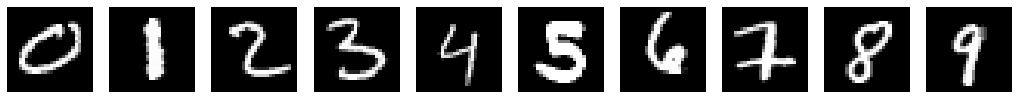

Source B


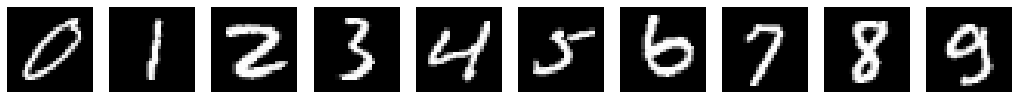

Output


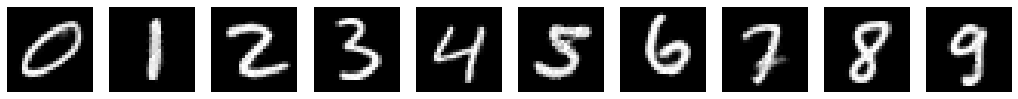

Time Cost: 0.8700170516967773 sec
Source A


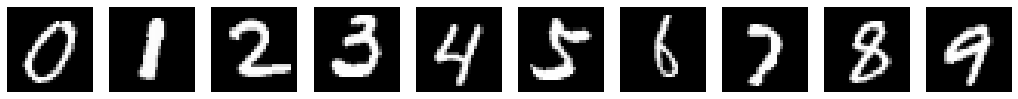

Source B


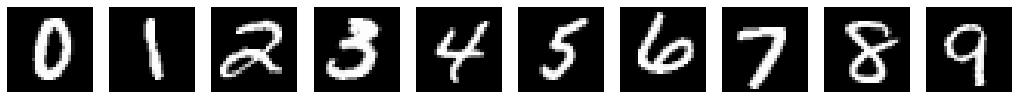

Output


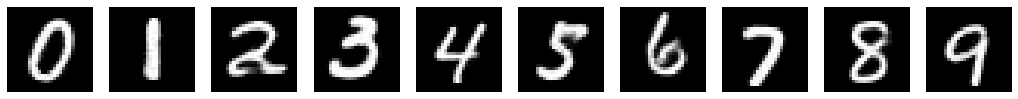

Time Cost: 0.9010179042816162 sec
Source A


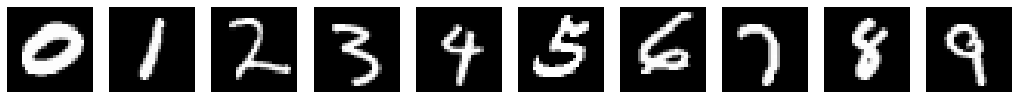

Source B


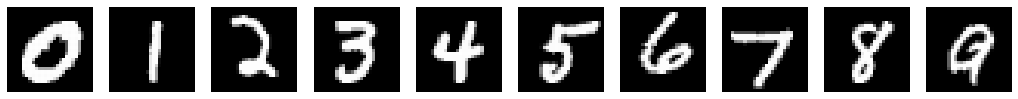

Output


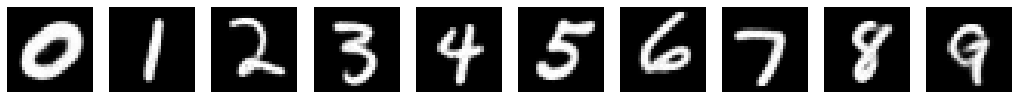

Time Cost: 0.5770015716552734 sec
Source A


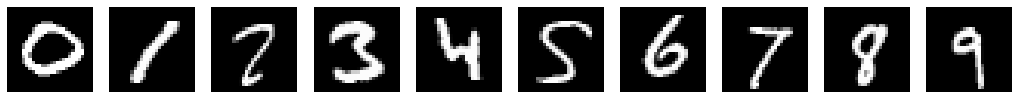

Source B


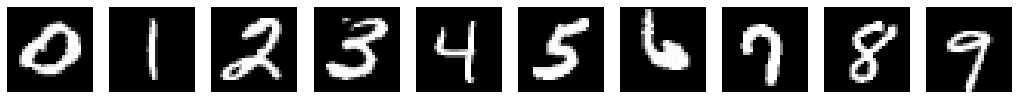

Output


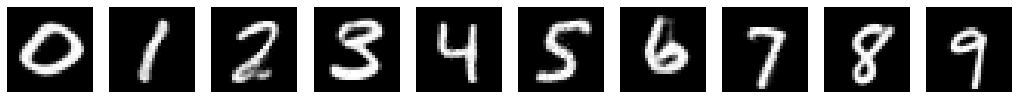

Time Cost: 0.9077146053314209 sec
Source A


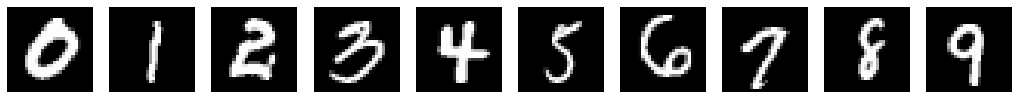

Source B


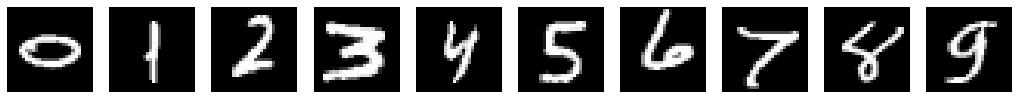

Output


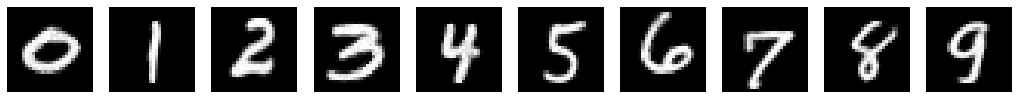

Time Cost: 0.493558406829834 sec
Source A


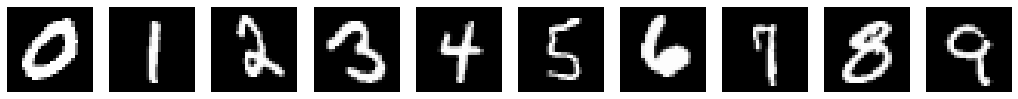

Source B


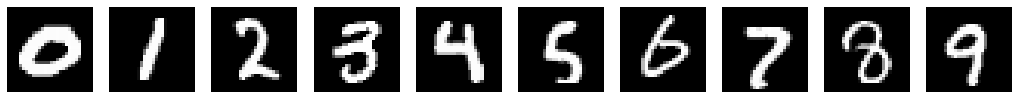

Output


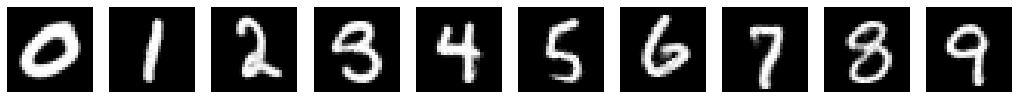

Time Cost: 0.9436676502227783 sec
Source A


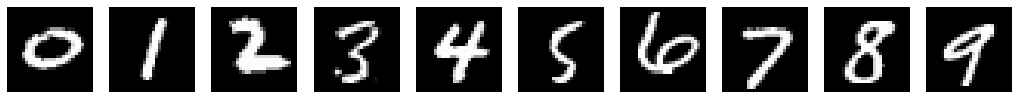

Source B


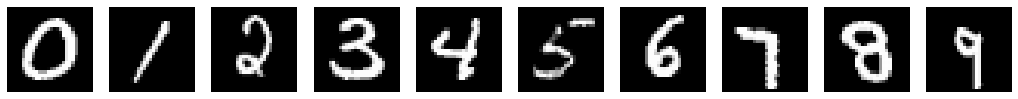

Output


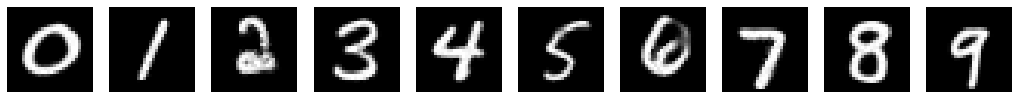

Time Cost: 0.42806220054626465 sec
Source A


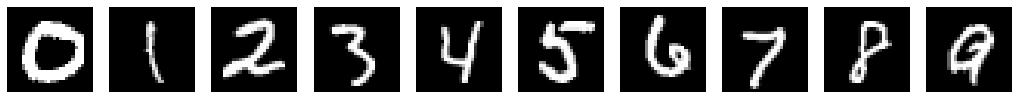

Source B


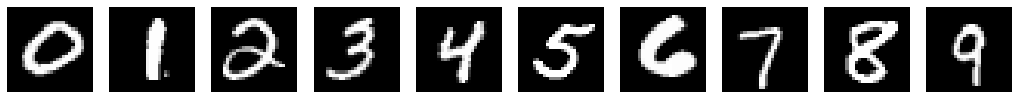

Output


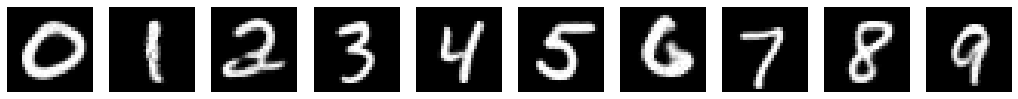

Time Cost: 0.8965158462524414 sec
Source A


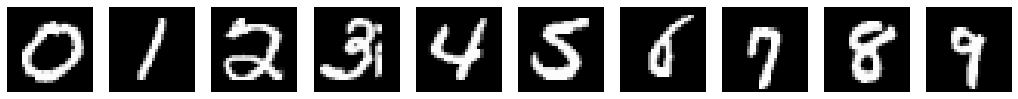

Source B


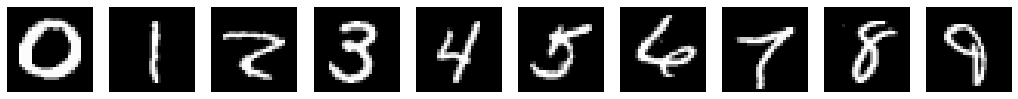

Output


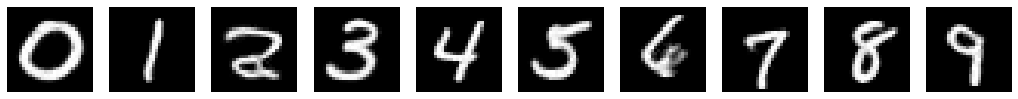

Time Cost: 0.4358036518096924 sec
Source A


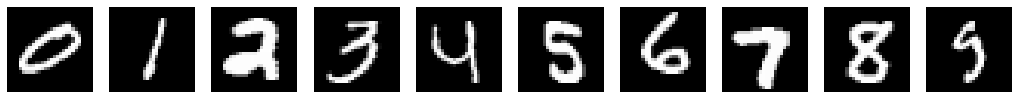

Source B


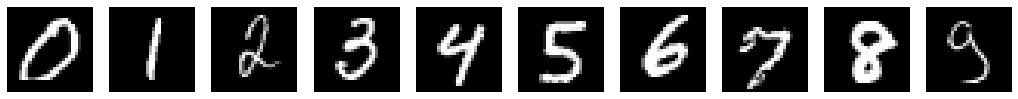

Output


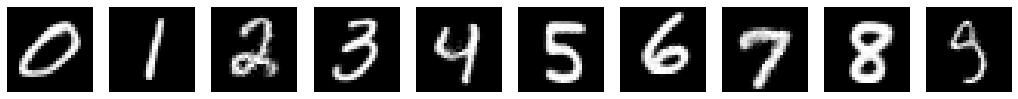

In [6]:
for _ in range(10):
    label_indices = []
    for i in range(10):
        l = [a for a in range(len(test_labels)) if test_labels[a]==i]
        label_indices.append(l)

    # indicesa = np.random.choice(test_images.shape[0], BATCH_SIZE, replace=False)
    # indicesb = np.random.choice(test_images.shape[0], BATCH_SIZE, replace=False)

    indicesa = []
    indicesb = []
    for i in range(10):
        a,b = np.random.choice(len(label_indices[i]), 2, replace=False)
        indicesa.append(label_indices[i][a])
        indicesb.append(label_indices[i][b])
    indicesa = np.array(indicesa)
    indicesb = np.array(indicesb)

    x_npa = test_images[indicesa].astype(np.float32)
    xa = torch.from_numpy(x_npa).to(DEVICE)

    x_npb = test_images[indicesb].astype(np.float32)
    xb = torch.from_numpy(x_npb).to(DEVICE)

    seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
    x0 = np.repeat(seed[None, ...], len(indicesa), 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)

    start_time = time.time()
    y, history = my_model.multi_infer(x0, [xa,xb], N_STEPS)
    time_cost = time.time()-start_time

    y = y.detach().cpu().numpy()
    n_show = len(indicesa)

    print("Time Cost:", time_cost, "sec")

    print("Source A")
    plt.figure(figsize=(18,3))
    for i in range(n_show):
        plt.subplot(1,n_show,i+1)
        plt.imshow(x_npa[i].reshape(map_size), cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.axis('off')
    plt.show()
    print("Source B")
    plt.figure(figsize=(18,3))
    for i in range(n_show):
        plt.subplot(1,n_show,i+1)
        plt.imshow(x_npb[i].reshape(map_size), cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.axis('off')
    plt.show()
    print("Output")
    plt.figure(figsize=(18,3))
    for i in range(n_show):
        plt.subplot(1,n_show,i+1)
        plt.imshow(y[i,...,0], cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

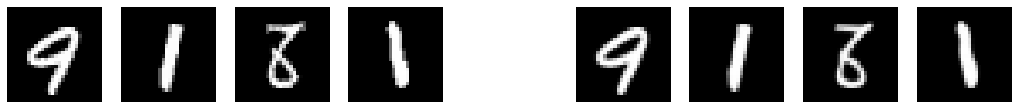

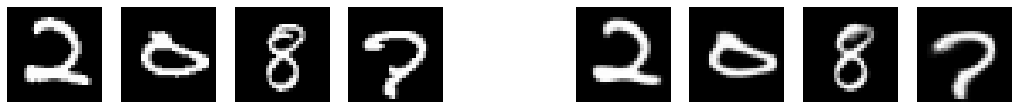

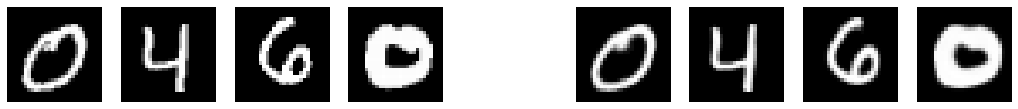

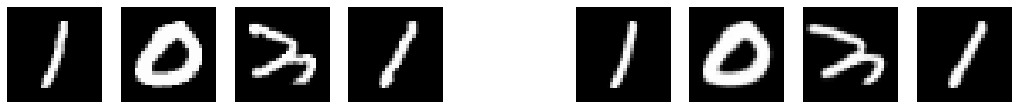

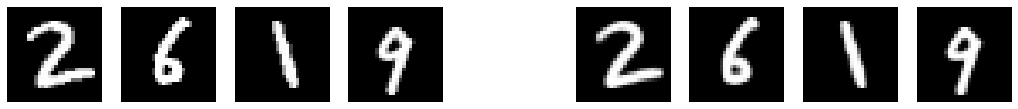

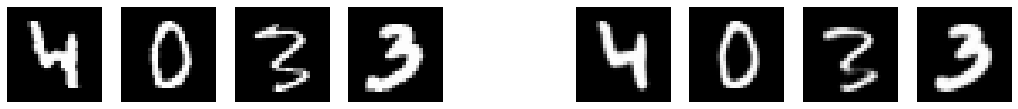

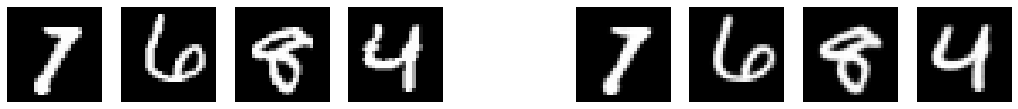

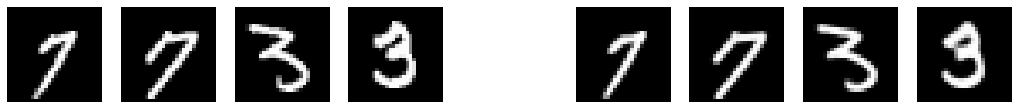

In [7]:
# n_batch = int(np.ceil(test_images.shape[0]/BATCH_SIZE))
BATCH_SIZE = 4
n_batch = 8
seq = np.random.choice(test_images.shape[0], test_images.shape[0], replace=False)
for index in range(n_batch):
    indices = seq[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
    x_np = test_images[indices].astype(np.float32)
    x = torch.from_numpy(x_np).to(DEVICE)

    seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
    x0 = np.repeat(seed[None, ...], len(indices), 0)
    x0 = torch.from_numpy(x0.astype(np.float32)).to(DEVICE)

    start_time = time.time()
    y, history = my_model.infer(x0, x, N_STEPS)
    time_cost = time.time()-start_time
    
    y = y.detach().cpu().numpy()
    n_show = len(indices)

    # print("Time Cost:", time_cost, "sec")
    plt.figure(figsize=(18,3))
    for i in range(n_show):
        plt.subplot(1,BATCH_SIZE*2+1,i+1)
        plt.imshow(x_np[i].reshape(map_size), cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.axis('off')
    for i in range(n_show):
        plt.subplot(1,BATCH_SIZE*2+1,i+1+BATCH_SIZE+1)
        plt.imshow(y[i,...,0], cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

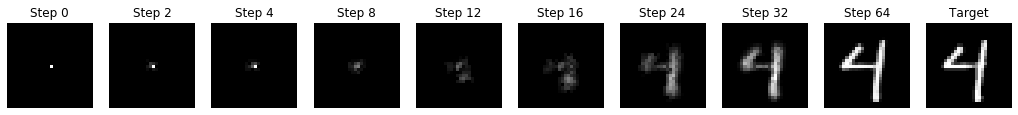

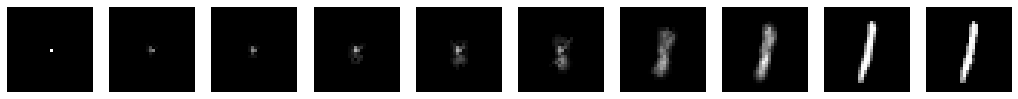

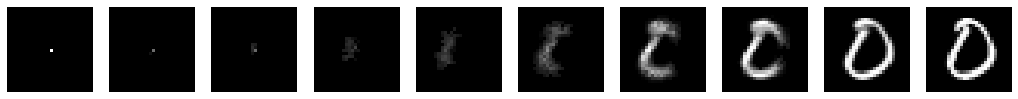

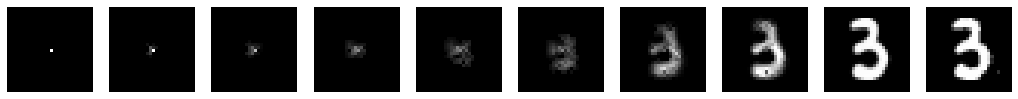

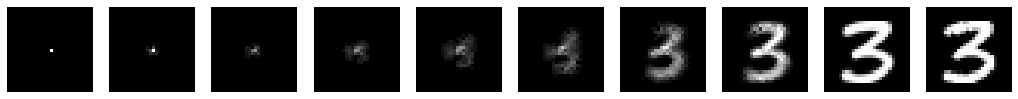

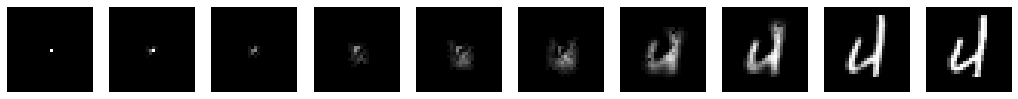

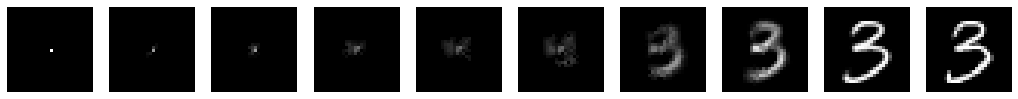

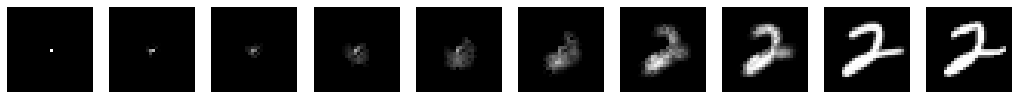

In [8]:
shown_indices = [0,2,4,8,12,16,24,32,64]
for i_batch in range(history[0].shape[0]):
    plt.figure(figsize=(18,3))
    for i,ind in enumerate(shown_indices):
        plt.subplot(1,len(shown_indices)+1,i+1)
        plt.imshow(history[ind][i_batch,...,0], cmap=plt.cm.gray, vmin=0, vmax=1)
        plt.axis('off')
        if i_batch==0:
            plt.gca().set_title("Step "+str(ind))
    plt.subplot(1,len(shown_indices)+1,len(shown_indices)+1)
    plt.imshow(x_np[i_batch].reshape(map_size), cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.axis('off')
    if i_batch==0:
        plt.gca().set_title("Target")
    plt.show()